In [1]:
import os, sys
from os.path import join
from collections import namedtuple
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sb
import pandas as pd
import torch

**NOTE** The results files have been renamed but the weights files not. They are named by time, and the runs were made in this order: 101, 121, 120

In [3]:
# Navigate to project route
if not os.getcwd().endswith('/enas-compression'):
    os.chdir('../..')
print(os.getcwd())

/Users/pscl/Development/Projects/enas-compression


In [4]:
sys.path.append('.')

In [5]:
from src.results import ResultsIO

In [6]:
res_path = 'results'
weights_path = 'weights'

In [7]:
# Color-blind friendly color-pallette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
# Previously: ['blue', 'black', 'red', 'purple','gray','cyan']

# Order of the experiments
exps = ['021','101','121','120','020','100',]

In [8]:
# Plotting Hyperparams
PlotArguments = namedtuple('PlotArguments', (
    'label_font',
    'title_font',
    'suptitle_size',
    'tick_size',
    'legend_fontsize',
    'boxplot_width',
))
pltargs = PlotArguments(
    label_font = {
        'size' : 22,
        'weight' : 'normal'
    },
    title_font = {
        'size' : 22,
        'weight' : 'normal'
    },
    suptitle_size = 28,
    tick_size = 16,
    legend_fontsize = 16,
    boxplot_width=0.6
)

In [9]:
best_acc_allexps = []
best_sizes_allexps = []

for exp in exps:
    best_acc = []
    for run in range(1,10+1):
        _, _, best_test_acc = \
            ResultsIO.load(res_path, f'2021-06-01_lossweights{exp}_{run}')
        best_acc.append(best_test_acc)
    best_acc_allexps.append(best_acc)
    
    best_sizes = []
    for run in range(1,10+1):
        best_size = torch.load(
            join(
                weights_path, 
                f'best-net_2021-06-01_lossweights{exp}_{run}.pth'
            )
        )['layer_2_linear.weight'].shape[0]
        best_sizes.append(best_size/256)
    best_sizes_allexps.append(best_sizes)

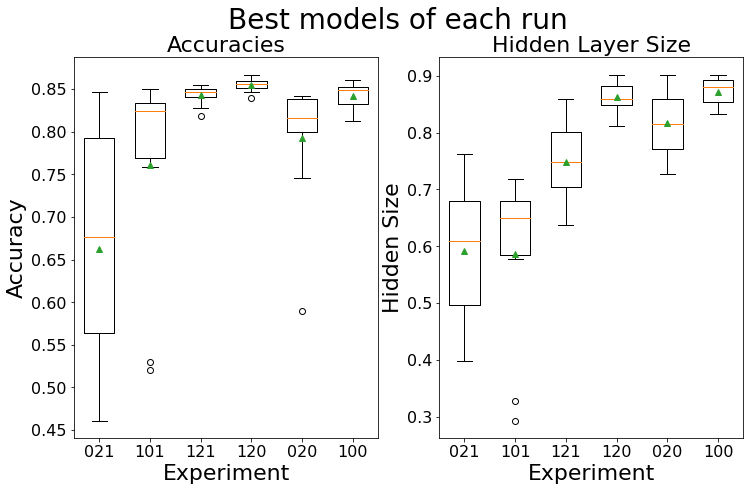

In [10]:
plt.figure(figsize=(12,7))
plt.suptitle('Best models of each run', fontsize=pltargs.suptitle_size)

def plot_boxplot(best):
    plt.boxplot(
        x=best,
        #x=[best_acc_dict['001'],best_acc_dict['020'],best_acc_dict['100'],best_acc_dict['021']],
        labels=exps,
        widths=pltargs.boxplot_width,
        autorange=True,
        showmeans=True
    )
plt.subplot(121)
plt.title('Accuracies', fontdict=pltargs.title_font)
plot_boxplot(best_acc_allexps)
plt.xlabel('Experiment', fontdict=pltargs.label_font)
plt.ylabel('Accuracy', fontdict=pltargs.label_font)
plt.xticks(fontsize=pltargs.tick_size)
plt.yticks(fontsize=pltargs.tick_size)

plt.subplot(122)
plt.title('Hidden Layer Size', fontdict=pltargs.title_font)
plot_boxplot(best_sizes_allexps)
plt.xlabel('Experiment', fontdict=pltargs.label_font)
plt.ylabel('Hidden Size', fontdict=pltargs.label_font)
plt.xticks(fontsize=pltargs.tick_size)
plt.yticks(fontsize=pltargs.tick_size)

#plt.tight_layout()
plt.show()

In [11]:
# Check if outliers are the same for experiment 101

best_acc_allexps = []
best_sizes_allexps = []

print('Experiment 101\n==============')
for run in range(1,10+1):
    print('Run', run)
    _, _, best_test_acc = \
        ResultsIO.load(res_path, f'2021-06-01_lossweights101_{run}')
    print(' Score:',best_test_acc, '<--' if best_test_acc < 0.6 else '')

    best_size = torch.load(
        join(
            weights_path, 
            f'best-net_2021-06-01_lossweights101_{run}.pth'
        )
    )['layer_2_linear.weight'].shape[0]
    print(' Size: ',f'{best_size/256:.4f}', '<--' if best_size/256 < 0.4 else '')


Experiment 101
Run 1
 Score: 0.8232 
 Size:  0.6641 
Run 2
 Score: 0.5199 <--
 Size:  0.2930 <--
Run 3
 Score: 0.8245 
 Size:  0.6797 
Run 4
 Score: 0.8009 
 Size:  0.6016 
Run 5
 Score: 0.8388 
 Size:  0.6367 
Run 6
 Score: 0.8268 
 Size:  0.6797 
Run 7
 Score: 0.8355 
 Size:  0.6797 
Run 8
 Score: 0.7581 
 Size:  0.5781 
Run 9
 Score: 0.8507 
 Size:  0.7188 
Run 10
 Score: 0.5296 <--
 Size:  0.3281 <--


In [12]:
def plot_runs_for_metric(metric_name:str, smoothing:int=3):

    fig, axs = plt.subplots(2,5,figsize=(25,10))
    
    plt.suptitle(f'Average {metric_name} Across Runs', fontsize=pltargs.suptitle_size, y=0.97, x=0.492)
    fig.text(0.485, 0., 'Iteration', ha='center', va='center', fontdict=pltargs.label_font)
    fig.text(0., 0.485, f'{metric_name}', ha='center', va='center', rotation='vertical', fontdict=pltargs.label_font)

    r_i, c_i = 0,0
    for i,run in enumerate(range(1,10+1)):
        avg, best, worst = [], [], []
        if c_i == 5:
            r_i += 1; c_i = 0
        axs[r_i][c_i].set_title(f'Run {i+1}', fontdict=pltargs.title_font)
        for exp, c in zip(*[exps, colors]):
            configs, results, best_test_acc = \
                ResultsIO.load(res_path, f'2021-06-01_lossweights{exp}_{run}')
            
            if metric_name == 'Accuracy':
                res = np.array(results.accuracy.averages)
            elif metric_name == 'Compression Rate':
                res = np.array(results.compression.averages)
            elif metric_name == 'Similarity Loss':
                res = np.array(results.loss.averages)
            else:
                ValueError(f'The value of {metric_name} is not accepted.')
            axs[r_i][c_i].plot(
                np.arange(0, len(res), smoothing),
                res[np.arange(0, len(res), smoothing)], 
                label=exp,  
                c=c,
                linewidth=2
            )

        # Hide top and right border
        axs[r_i][c_i].spines['top'].set_visible(False)
        axs[r_i][c_i].spines['right'].set_visible(False)

        # Add light grid to plots
        axs[r_i][c_i].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

        # Change tick size
        axs[r_i][c_i].tick_params(axis = 'both', which = 'major', labelsize = pltargs.tick_size)
        axs[r_i][c_i].tick_params(axis = 'both', which = 'minor', labelsize = pltargs.tick_size)

        # Enforce y range
        if metric_name != 'Similarity Loss':
            axs[r_i][c_i].set_ylim((0.15,1.05))
        else:
            axs[r_i][c_i].set_ylim((0.,.45))

        c_i += 1

    plt.legend(bbox_to_anchor=(1,1), fontsize=pltargs.legend_fontsize)
    plt.tight_layout(pad=3.)
    plt.show()

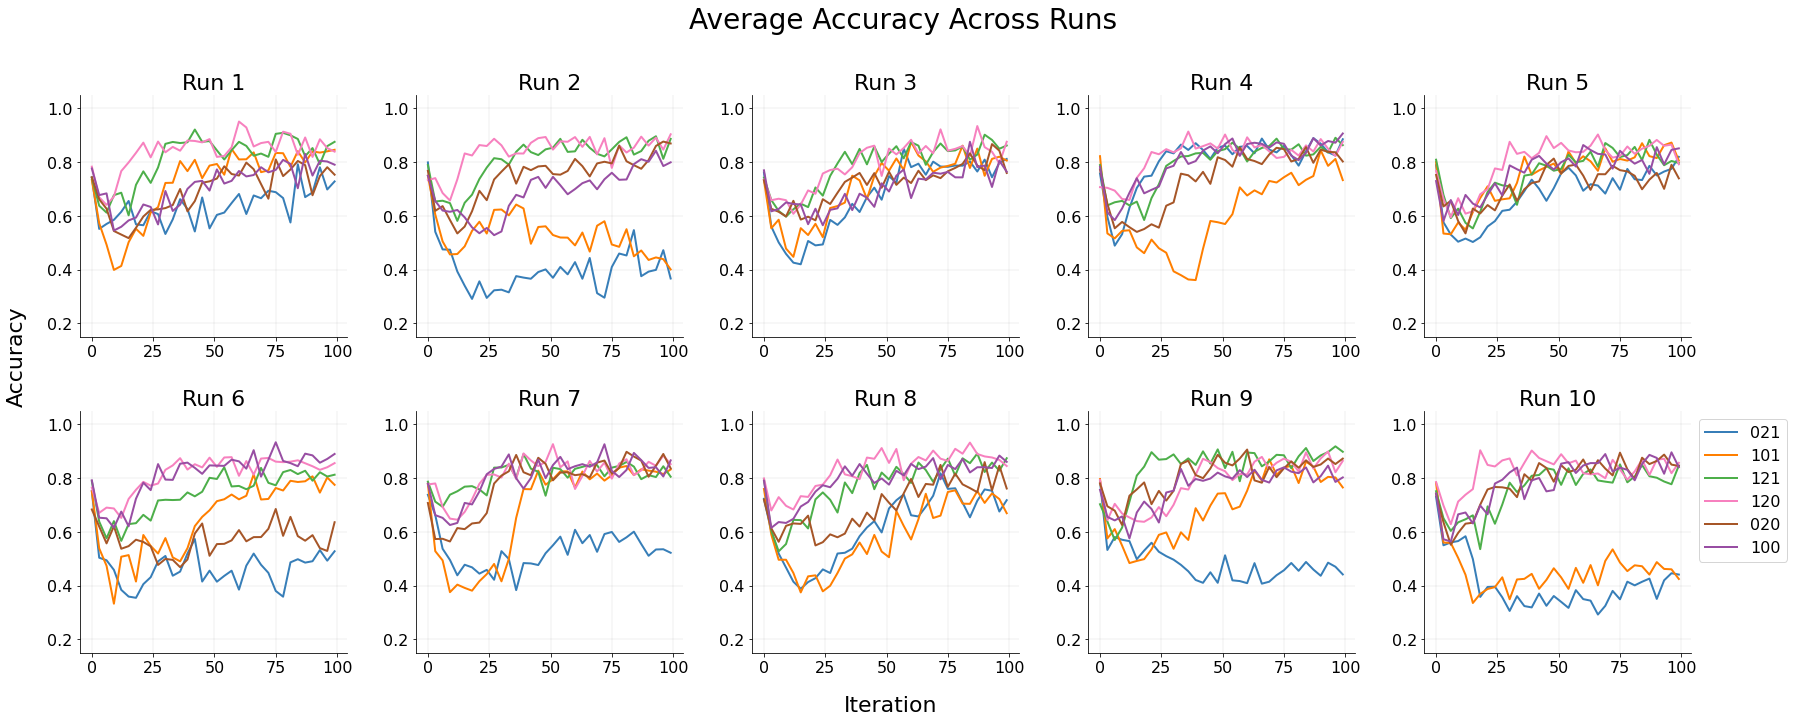

In [13]:
plot_runs_for_metric('Accuracy')

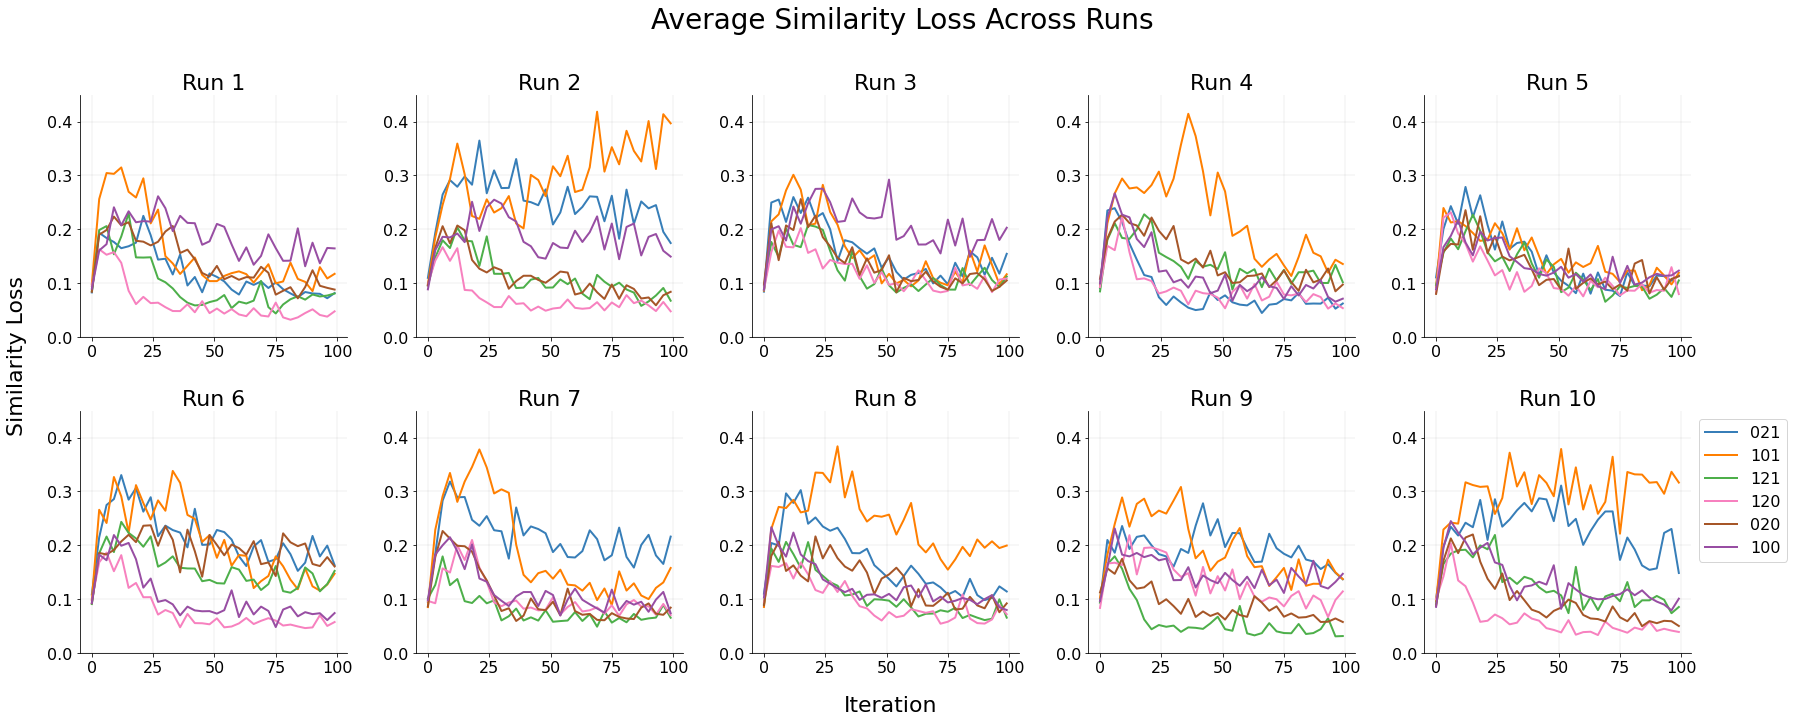

In [14]:
plot_runs_for_metric('Similarity Loss')

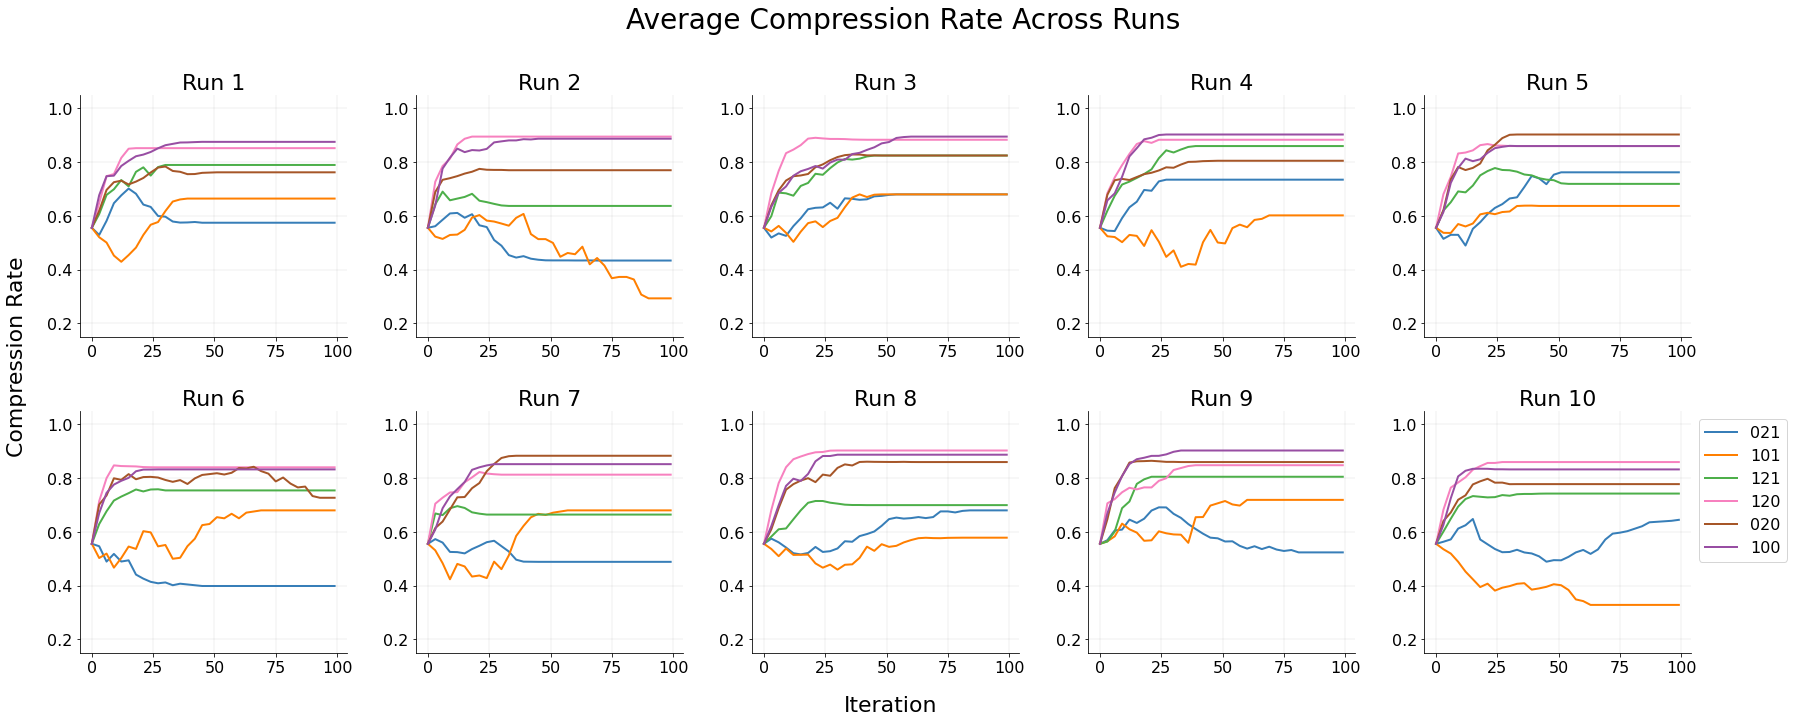

In [15]:
plot_runs_for_metric('Compression Rate')

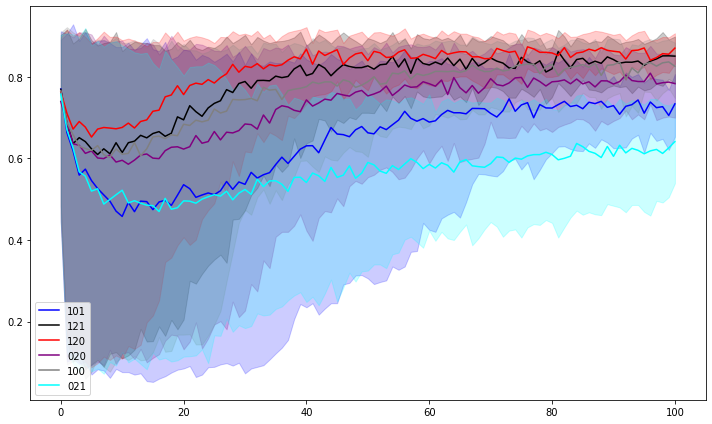

In [166]:
plt.figure(figsize=(10,6))
for exp, c in zip(*[exps, colors]):
    avg, best, worst = [], [], []
    #plt.subplot(4,3,i+1)
    #plt.title(f'Run {i+1}')
    #for exp in exps:
    for i,run in enumerate(range(1,10+1)):        
        configs, results, best_test_acc = \
            ResultsIO.load(res_path, f'2021-06-01_lossweights{exp}_{run}')
        avg.append(results.accuracy.averages)
        best.append(results.accuracy.best)
        worst.append(results.accuracy.worst)
    avg = np.mean(np.array(avg), axis=0)
    best = np.mean(np.array(best), axis=0)
    worst = np.mean(np.array(worst), axis=0)
    plt.fill_between(range(101), best, worst, alpha=0.2, color=c)
    plt.plot(avg, label=exp, c=c)
    #plt.plot(best, c=c, linestyle='--', alpha=0.3)
    #plt.plot(worst, c=c, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()